In [1]:
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import cmaps
import glob
from REMO2020_mod import modelclass, open_mfdataset, eobs_preci_open, calc_remo_precipitation, domainclass, plotclass, remo_plotter

In [2]:
from dask.distributed import Client, progress
import dask
dask.config.set({'temporary_directory': '/scratch/g/g300096/dask/tmp'})
client = Client()
client

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37117 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300096/levante-spawner-preset//proxy/37117/status,
Dashboard: /user/g300096/levante-spawner-preset//proxy/37117/status,Workers: 16
Total threads: 256,Total memory: 486.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39985,Workers: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/37117/status,Total threads: 256
Started: Just now,Total memory: 486.93 GiB
Comm: tcp://127.0.0.1:46595,Total threads: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/37225/status,Memory: 30.43 GiB
Nanny: tcp://127.0.0.1:35337,


In [3]:
# define the runs to be plotted
modelruns =[] # init

# configuration for Fig. 3
modelruns.append(modelclass("056524","REMO2015",False,varname='Ddayprec'))
modelruns.append(modelclass("036030","REMO2020$_{27}$",True,varname='Ddayprec'))
modelruns.append(modelclass("036032","REMO2020$_{49}$",True,varname='Ddayprec'))
modelruns.append(modelclass("036034","REMO2020$_{49}$ MERRA-2",True,varname='Ddayprec'))
modelruns.append(modelclass("036039","REMO2020$_{49}$ iMOVE",True,varname='Ddayprec'))

# configuration for Fig. 5
#modelruns.append(modelclass("056524","REMO2015",False,varname='Ddayprec'))
#modelruns.append(modelclass("036030","REMO2020$_{27}$",True,varname='Ddayprec'))
#modelruns.append(modelclass("036031","REMO2020$_{27}$ Shallow",True,varname='Ddayprec'))

# configuration for Fig. 6
#modelruns.append(modelclass("036032","REMO2020$_{49}$",True,varname='Ddayprec'))
#modelruns.append(modelclass("036033","REMO2020$_{49}$ no-Prog",True,varname='Ddayprec'))
#modelruns.append(modelclass("036037","REMO2020$_{49}$ Shallow",True,varname='Ddayprec'))
#modelruns.append(modelclass("036036","REMO2020$_{49}$ Wetcore",True,varname='Ddayprec'))

In [4]:
# give path, prefix and suffix (the main name for the plots)
figpath = './figures/'
prefix = 'eobs_preci_abs_seas_'
suffix = 'REMO2020_2749_main' # Fig. 3
#suffix = 'REMO2020_27_conv' # Fig. 5
#suffix = 'REMO2020_49_conv' # Fig. 6

In [5]:
# REMO and EOBS datapath
rdata = './data_in/model_data/'
edata = './data_in/E-OBS/'

In [6]:
# define star year and end year
ystart=2001
yend=2010

In [7]:
# Define the order of seasons to be used (also when plotting)
seasons = ["DJF","MAM","JJA","SON"]

In [8]:
# Load the lake mask
lake_mask = xr.open_dataset(rdata+"FLake_input/flake_v3_glcc_defD10.0m_frac_EUR-11.nc")["FLFRA"]

In [9]:
# E-OBS version
eobv='v30.0e'

In [10]:
# Eobs file name
eobsfile = edata+eobv+"/day/var/rr/rr_ens_mean_0.1deg_reg_"+eobv+".nc"

In [11]:
# set the minimum number days with data per month to be included
dlim=21

In [12]:
# lake fraction cut-off limit
clake = 0.5

In [13]:
# Target grid
trggrid = "EUR-11"

In [14]:
# calculate eobs variables
eobs_mdata, final_mask, ndays_ps = eobs_preci_open(eobsfile,ystart,yend,trggrid,dlim,lake_mask,clake)

/home/g/g300096/scripts/remo2_2020_runs/remo2020-evaluation-paper/REMO2020_mod.py:119: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 201. This could degrade performance. Instead, consider rechunking after loading.
  eobs_daydata = xr.open_dataset(
/home/g/g300096/scripts/remo2_2020_runs/remo2020-evaluation-paper/REMO2020_mod.py:119: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 464. This could degrade performance. Instead, consider rechunking after loading.
  eobs_daydata = xr.open_dataset(
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 41.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#loa

In [15]:
yearlist = np.arange(ystart,yend+1)
for obj in modelruns:
    obj.filenames = []
    for year in yearlist:
        pattern = rdata+"remo_results_"+obj.userexp+"/"+str(year)+"/e"+obj.userexp+"m*.nc"
        obj.filenames += glob.glob(pattern)
    obj.filenames.sort()

In [16]:
# Set halo zone length (will be cutted out)
halo = 8

In [17]:
# calculate the precipitation difference to EOBS
ii = 0
for obj in modelruns:   
    ds = open_mfdataset(obj.filenames, parallel=False, chunks='auto')
    precip, dpsdummy = calc_remo_precipitation(ds)
    # Merge data (get identical coordinates)
    precip_all = xr.merge([precip.rename("totpre"), eobs_mdata.rename("eobs_m_data"),final_mask.rename("mask")], compat="override", join="override")
    # apply masking (eobs+lake) and subtract the values, finally making seasonal means
    pre_mod_tmp = precip_all.totpre.where(precip_all.mask,drop=False).groupby("time.season").sum(skipna=True)
    if(ii == 0):
        final_mask_seas = precip_all.mask.groupby("time.season").sum(skipna=True) #.sum(dim="time").compute()
        pre_eobs_abs = precip_all.eobs_m_data.where(precip_all.mask,drop=False).groupby("time.season").sum(skipna=True).squeeze()
        # small adjustment to zero values (occur near borders)
        final_mask_seas = final_mask_seas.where(pre_eobs_abs > 0, drop=False)
        pre_eobs_abs = pre_eobs_abs.where(final_mask_seas > 0, drop=False)
        # calculate dps
        tmp_mask = xr.merge([pre_eobs_abs, ndays_ps.rename("mask")], compat="override", join="override")
        dps = tmp_mask.mask.where(final_mask_seas > 0, drop=False)
        # change pre_eobs_abs units from mm/season -> mm/day
        pre_eobs_abs = (pre_eobs_abs / dps).compute()
    # get identical coordinates
    final_tmp = xr.merge([pre_mod_tmp.rename("totpre"),dps.rename("dps"),pre_eobs_abs.rename("pre_eobs_abs"),final_mask_seas.rename("final_mask_seas")], compat="override", join="override")
    obj.vardiff = (final_tmp.totpre/final_tmp.dps - final_tmp.pre_eobs_abs).where(final_tmp.final_mask_seas, drop=False).squeeze()
    obj.vardiff = obj.vardiff.isel(rlat=slice(halo+1,obj.vardiff.sizes["rlat"]-halo+1), rlon=slice(halo+1,obj.vardiff.sizes["rlon"]-halo+1)).compute()
    # not used, set to zero
    obj.mask = np.zeros(len(seasons))
    # increase counter
    ii = ii + 1
    #t_stat
    if(obj.r2020file):
        pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude,ds.rotated_latitude_longitude.grid_north_pole_latitude)
        rotated_pole = ccrs.RotatedPole(pole[0], pole[1])
        extent = ([ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()], rotated_pole)
        
    # clean memory
    del ds, precip, dpsdummy, precip_all, pre_mod_tmp, final_tmp
# Clean memory    
del tmp_mask
# cut also halo so domain mean will be comparable
pre_eobs_abs = pre_eobs_abs.isel(rlat=slice(halo+1,pre_eobs_abs.sizes["rlat"]-halo+1), rlon=slice(halo+1,pre_eobs_abs.sizes["rlon"]-halo+1)).compute()

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 189.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 189.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sendi

In [18]:
# define the domains to be plotted
domaininfo =[] # init
# configuration for Fig. 3
domaininfo.append(domainclass("EU",[-22.5,47.5,30,72.5], hspace=0.35))

# configuration for Figs. 5 and 6
#domaininfo.append(domainclass("CEU",[-2,26,36,55], hspace=0.35, xlocs=range(-180,180,5), ylocs=range(-90,90,5)))

In [19]:
# define plotclasses for absolute and difference (model) plots
absplotc = plotclass(label='Precipitation [mm/day]', lspace=np.linspace(0,1,10), vmin=0, vmax=5, linvert=False, cmapp=cmaps.GMT_drywet)
modplotc = plotclass(label='$\Delta$Precipitation [mm/day]', lspace=np.linspace(0,1,30), vmin=-3, vmax=3, linvert=True, cmapp=cmaps.BlueWhiteOrangeRed)

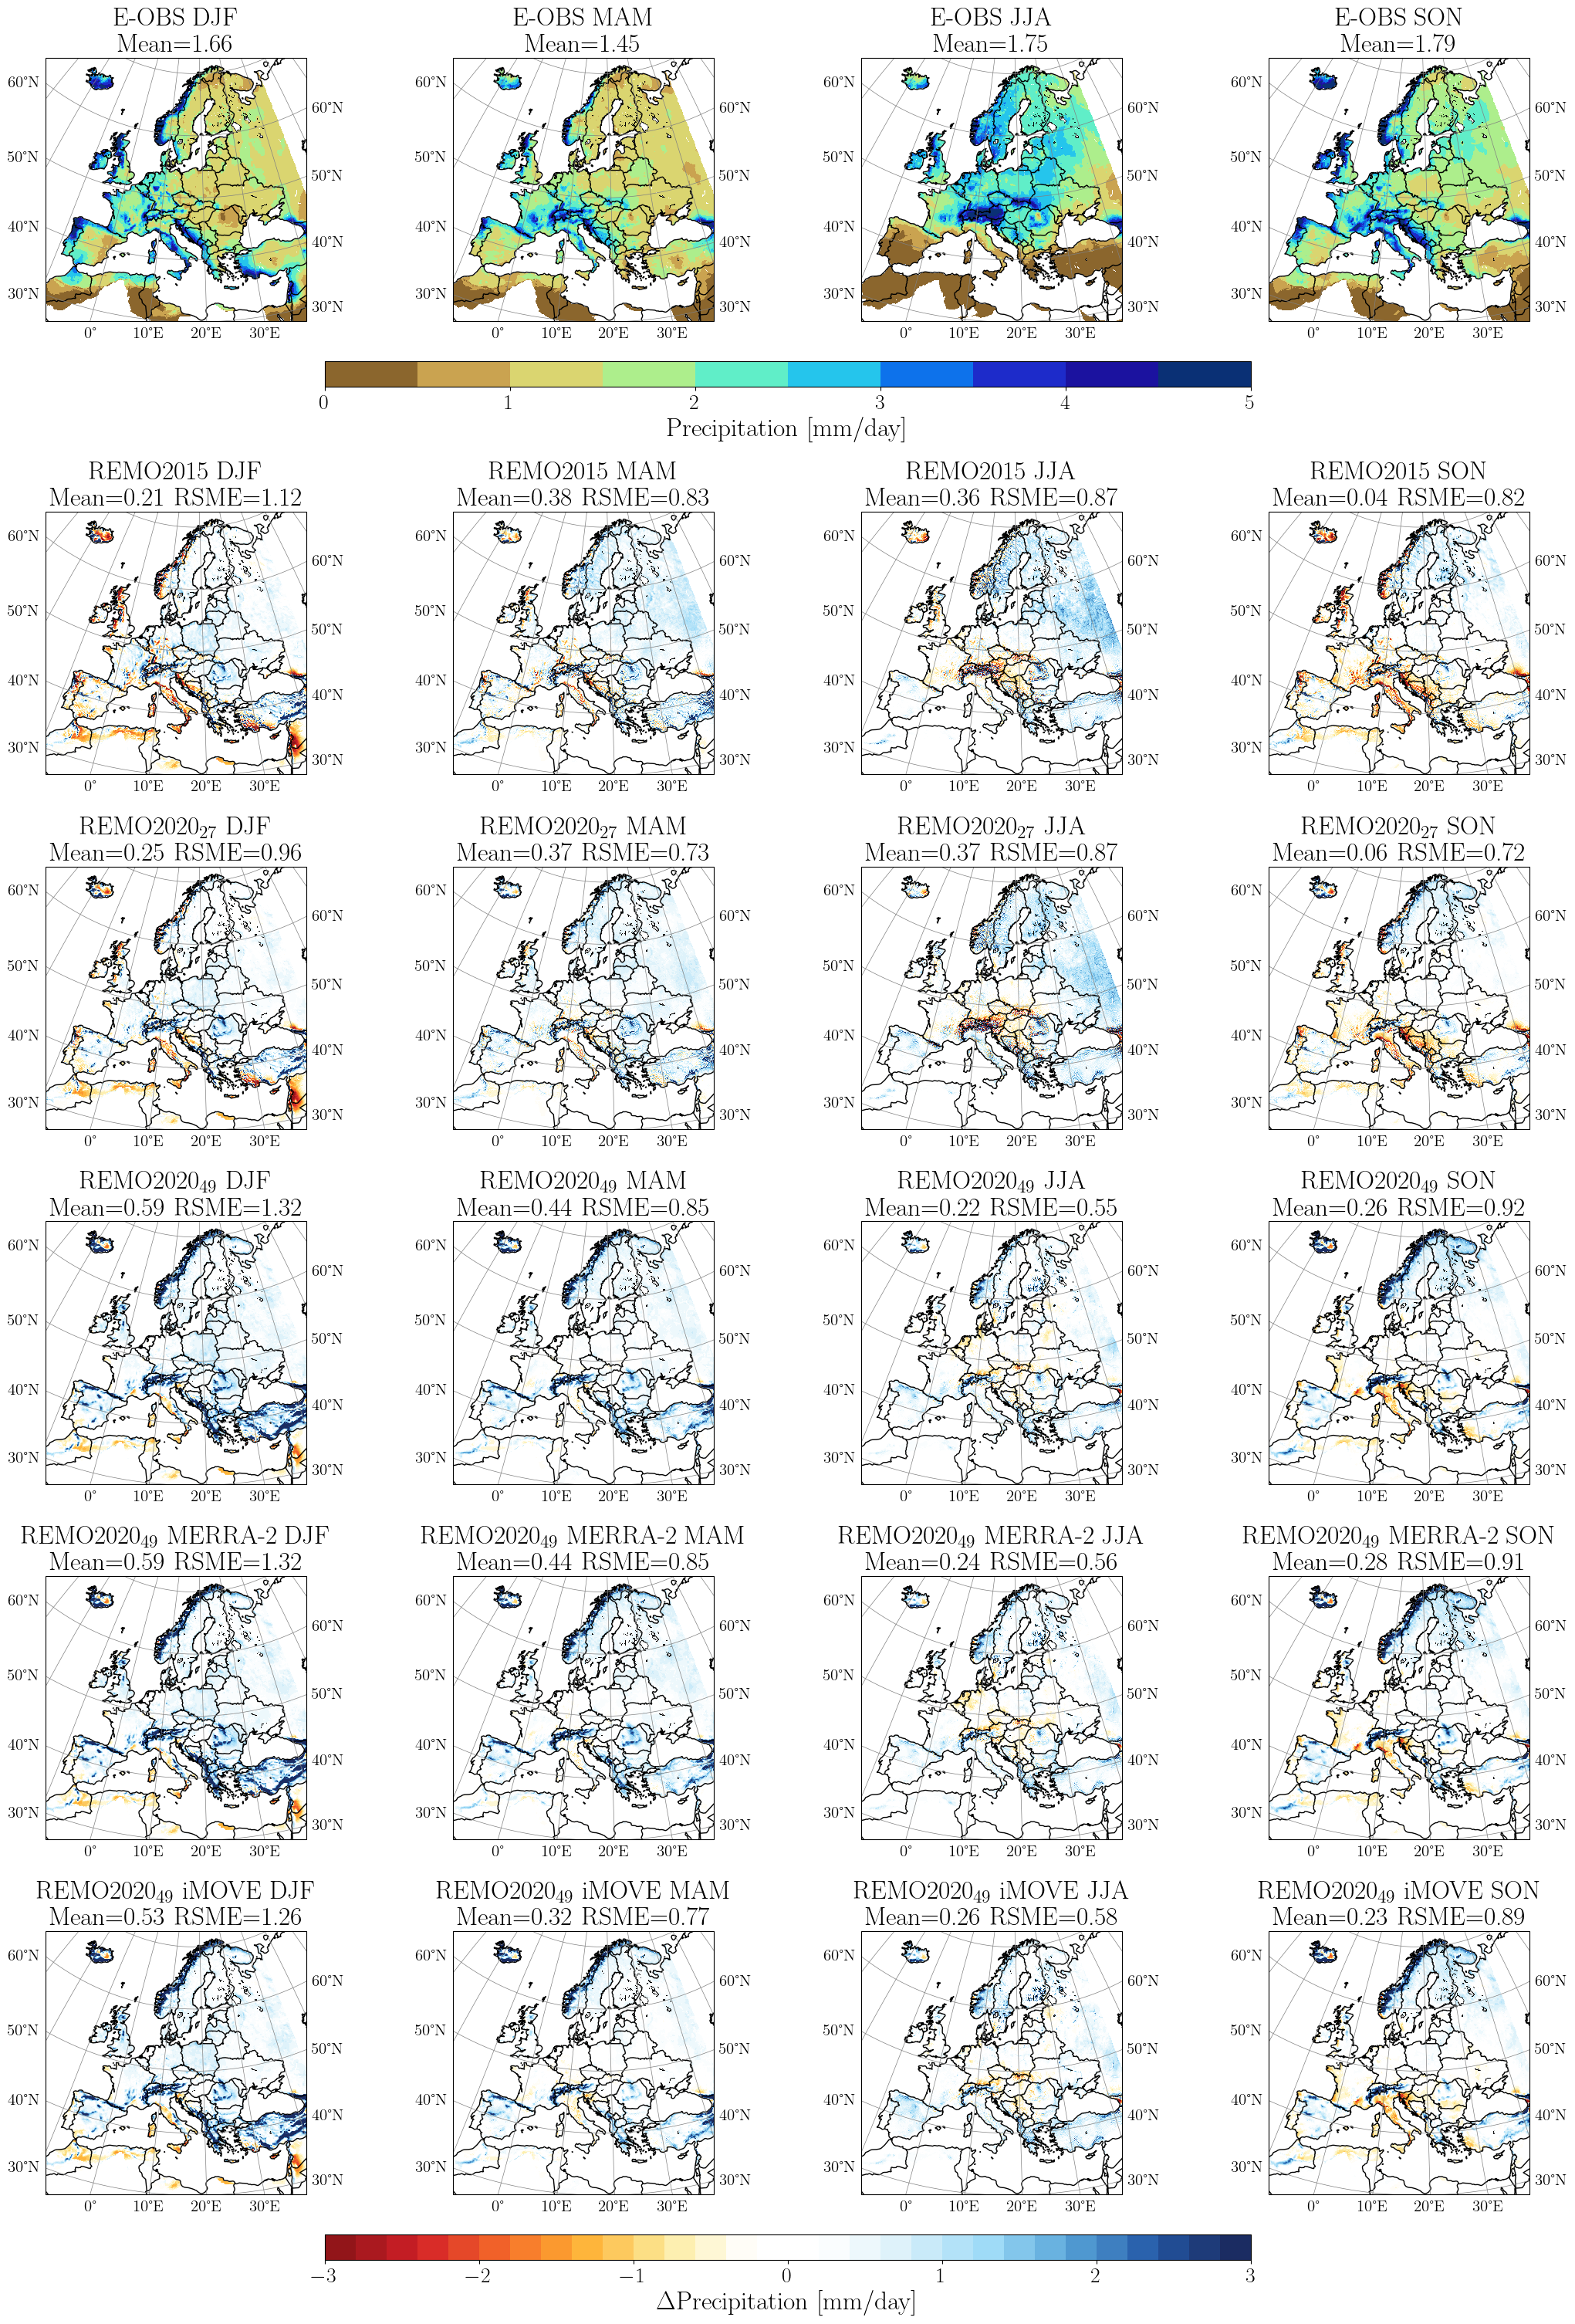

In [20]:
# Loop over domains
for dom in range(len(domaininfo)):
    # Create figure name
    figname=prefix+domaininfo[dom].name+'_'+suffix
    # Call plotter
    remo_plotter(absplotc,modplotc,domaininfo[dom],modelruns,"E-OBS",pre_eobs_abs,seasons,pole,False,figpath,figname)

In [21]:
# should we dump the model difference data to disk (e.g. for further analysis)
ldump=True
dumppath=rdata+'Tpredata/'

In [22]:
if(ldump):
    for obj in modelruns:
        obj.vardiff.rename(obj.varname).to_netcdf(dumppath+'/'+obj.userexp+'_'+obj.varname+'.nc',mode='w')